# Portfolio Project 1: Regression 

### Task
Predict the age of abalone from physical measurements only.

### Problem
Typically, the age of an abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope. This process is tedious and time-consuming. 

### Solution
Create a machine learning algorithm that will predict the age of an abalone from physical measurements only. 

## Dataset information 

- 8 attributes
- 4177 instances

`Sex`: nominal - M (male), F (female), I (infant)

`Length`: continuous - longest shell measurement (in mm)

`Diameter`: continuous - measurement perpendicular to legnth (in mm)

`Height`: continuous - with meat in shell (in mm)

`Whole weight`: continuous - the whole abalone (in grams)

`Shucked weight`: continuous - weight of the meat (in grams)

`Viscera weight`: continuous - gut weight after bleeding (in grams)

`Shell weight`: continuous - after being dried (in grams)

`Rings`: integer - +1.5 gives the age in years

## Import librairies 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas_profiling import ProfileReport

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Import data 

In [2]:
DATAPATH = 'data/abalone.data'

data = pd.read_csv(DATAPATH, header=None, index_col=False)
data.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']

data.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
profile = ProfileReport(data)
profile

D:\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,9
Number of observations,4177
Total Missing (%),0.0%
Total size in memory,293.8 KiB
Average record size in memory,72.0 B
Numeric,3
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,5


## Exploratory Data Analysis (EDA) 

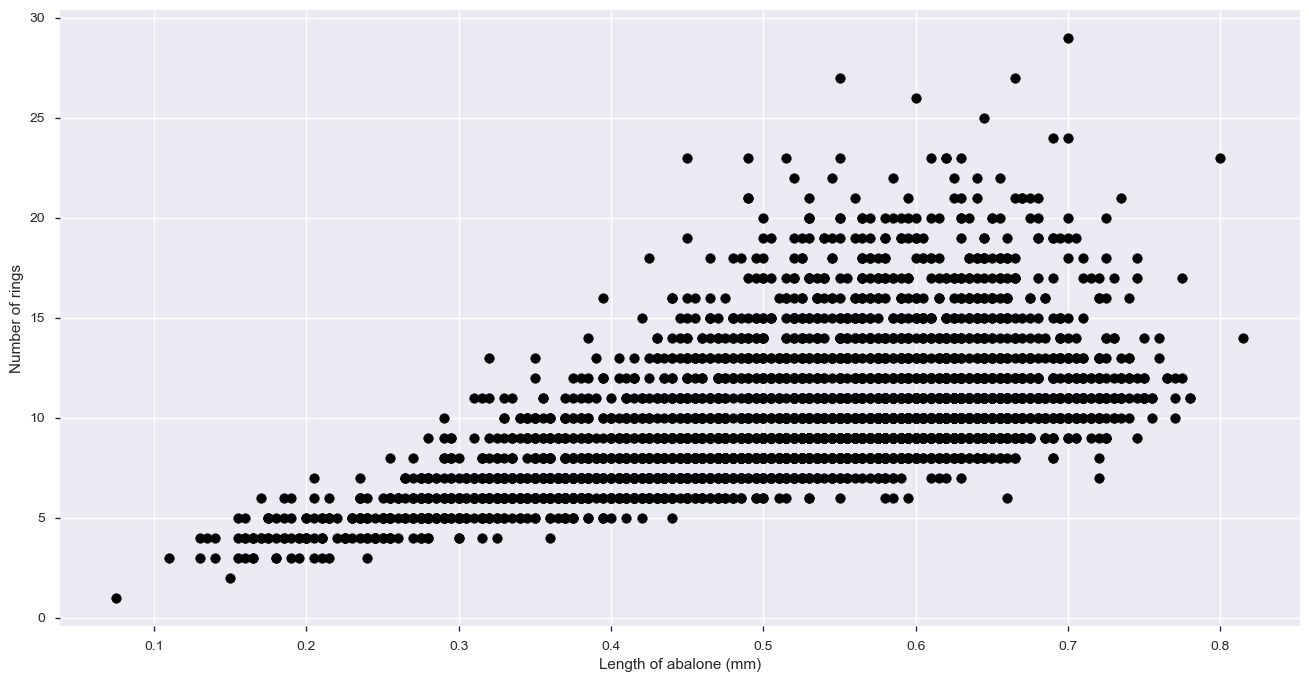

In [4]:
plt.figure(figsize=(16,8))
plt.scatter(data['length'], data['rings'], c='black')
plt.xlabel('Length of abalone (mm)')
plt.ylabel('Number of rings')
plt.show()

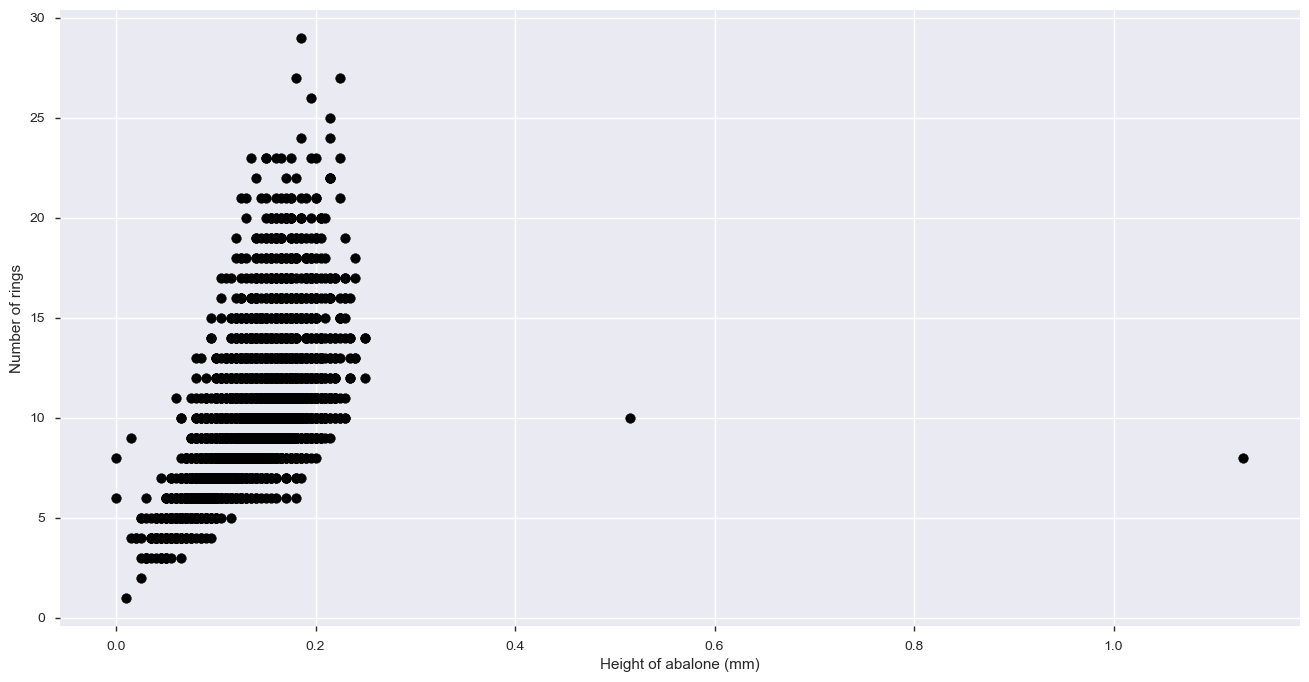

In [5]:
plt.figure(figsize=(16,8))
plt.scatter(data['height'], data['rings'], c='black')
plt.xlabel('Height of abalone (mm)')
plt.ylabel('Number of rings')
plt.show()

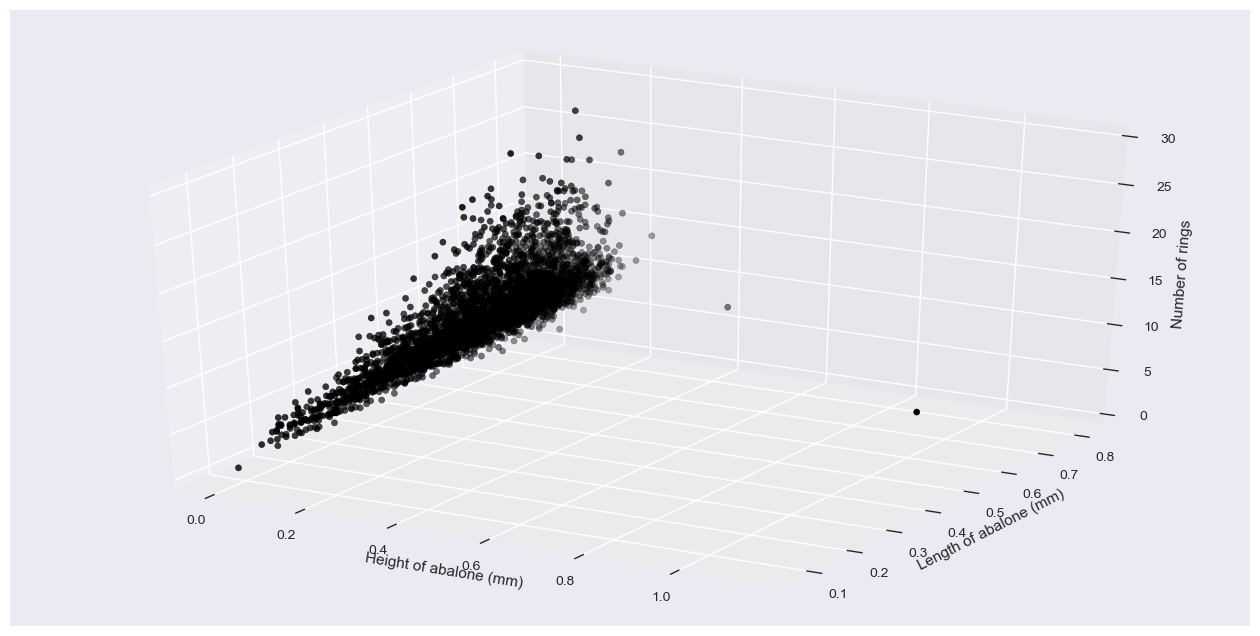

In [6]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection='3d')

ax.set_xlabel('Height of abalone (mm)')
ax.set_ylabel('Length of abalone (mm)')
ax.set_zlabel('Number of rings')
ax.scatter3D(data['height'], data['length'], data['rings'], c='black');

plt.show()

### one-hot encoding

In [8]:
encoded_data = pd.get_dummies(data)
encoded_data.head()

print(encoded_data.shape)

(4177, 11)


## Modelling 

### Split dataset 

In [9]:
training_set = encoded_data.iloc[:4099, :]
validation_set = encoded_data.iloc[4099:, :]

print(validation_set.shape)
print(training_set.shape)

(78, 11)
(4099, 11)


### Baseline model: multiple linear regression 

In [10]:
X = training_set[['length', 'height']]
y = training_set['rings'].values.reshape(-1, 1)

X_val = validation_set[['length', 'height']]
y_val = validation_set['rings'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [11]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_reg_pred = lin_reg.predict(X_test)

# Test set RMSE
test_rmse = mean_squared_error(y_test, lin_reg_pred, squared=False)
print(f'Test RMSE: {test_rmse}')

# Validation set RMSE
lin_reg_pred_val = lin_reg.predict(X_val)
val_rmse = mean_squared_error(lin_reg_pred_val, y_val, squared=False)

print(f'Validation RMSE: {val_rmse}')

Test RMSE: 2.5679099174951547
Validation RMSE: 1.5661783782311625


### Multiple linear regression with regularization (ridge regression) 

In [12]:
ridge = Ridge()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_root_mean_squared_error', cv=5)

ridge_regressor.fit(X_train, y_train);

print(ridge_regressor.best_params_)
print(-ridge_regressor.best_score_)

{'alpha': 1}
2.6564563658448885


In [13]:
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(X_train, y_train)

ridge_reg_pred = ridge_reg.predict(X_test)

# Test RMSE
test_rmse = mean_squared_error(y_test, ridge_reg_pred, squared=False)
print(f'Test RMSE: {test_rmse}')

# Validation RMSE
ridge_reg_pred_val = ridge_reg.predict(X_val)
val_rmse = mean_squared_error(y_val, ridge_reg_pred_val, squared=False)

print(f'Validation RMSE: {val_rmse}')

Test RMSE: 2.5871300097108296
Validation RMSE: 1.5640813253014876


### Multiple linear regression with regularization (lasso) 

In [14]:
lasso = Lasso(tol=0.05)

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)

lasso_regressor.fit(X_train, y_train)

print(lasso_regressor.best_params_)
print(-lasso_regressor.best_score_)

{'alpha': 0.01}
7.130917624445476


In [15]:
lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(X_train, y_train)

lasso_reg_pred = lasso_reg.predict(X_test)

# Test RMSE
test_rmse = mean_squared_error(y_test, lasso_reg_pred, squared=False)
print(f'Test RMSE: {test_rmse}')

# Validation RMSE
lasso_reg_pred_val = lasso_reg.predict(X_val)
val_rmse = mean_squared_error(y_val, lasso_reg_pred_val, squared=False)

print(f'Validation RMSE: {val_rmse}')

Test RMSE: 2.610473125813745
Validation RMSE: 1.5563831232308813


## Decision-tree based models 

In [16]:
X = training_set.drop(['rings' ,'diameter', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'], axis=1)
y = training_set['rings'].values.reshape(-1, 1)

X_val = validation_set.drop(['rings' ,'diameter', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'], axis=1)
y_val = validation_set['rings'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Random forest 

In [17]:
rf = RandomForestRegressor()

parameters = {'n_estimators': [int(x) for x in np.linspace(100, 1000, 10)]}

rf_regressor = GridSearchCV(rf, parameters, scoring='neg_mean_squared_error', cv=5)
rf_regressor.fit(X_train, y_train.ravel())

print(rf_regressor.best_params_)
print(-rf_regressor.best_score_)

{'n_estimators': 700}
8.388480082836542


In [18]:
rf_reg = RandomForestRegressor(n_estimators=300)
rf_reg.fit(X_train, y_train.ravel())

rf_reg_pred = rf_reg.predict(X_test)

# Test RMSE
test_rmse = mean_squared_error(y_test, rf_reg_pred, squared=False)
print(f'Test RMSE: {test_rmse}')

# Validation RMSE
rf_reg_pred_val = rf_reg.predict(X_val)
val_rmse = mean_squared_error(y_val, rf_reg_pred_val, squared=False)
print(f'Validation RMSE: {val_rmse}')

Test RMSE: 2.655425182582297
Validation RMSE: 2.2334462670996813


### Bagging 

In [19]:
bg = BaggingRegressor()

parameters = {
    'n_estimators': [int(x) for x in np.linspace(10, 1000, 10)],
    'max_samples': [float(x) for x in np.arange(0.1, 1.1, 0.1)],
}

bg_regressor = GridSearchCV(bg, parameters, scoring='neg_mean_squared_error', cv=5)
bg_regressor.fit(X_train, y_train.ravel())

print(bg_regressor.best_params_)
print(-bg_regressor.best_score_)

{'max_samples': 0.1, 'n_estimators': 1000}
6.579813965902899


In [20]:
bg_reg = BaggingRegressor(n_estimators=450, max_samples=0.1)
bg_reg.fit(X_train, y_train.ravel())

bg_reg_pred = rf_reg.predict(X_test)

# Test RMSE
test_rmse = mean_squared_error(y_test, bg_reg_pred, squared=False)
print(f'Test RMSE: {test_rmse}')

# Validation RMSE
bg_reg_pred_val = rf_reg.predict(X_val)
val_rmse = mean_squared_error(y_val, bg_reg_pred_val, squared=False)
print(f'Validation RMSE: {val_rmse}')

Test RMSE: 2.655425182582297
Validation RMSE: 2.2334462670996813


### LightGBM 

In [48]:
params = {
    'learning_rate': '0.01'
}

train_data = lgb.Dataset(X_train.values, label=y_train.ravel())

In [49]:
lgb_reg = lgb.train(params, train_data, 100)

In [51]:
lgb_reg_pred = lgb_reg.predict(X_test)

# Test RMSE
test_rmse = mean_squared_error(y_test, lgb_reg_pred, squared=False)
print(f'Test RMSE: {test_rmse}')

# Validation RMSE
lgb_reg_pred_val = lgb_reg.predict(X_val)
val_rmse = mean_squared_error(y_val, lgb_reg_pred_val, squared=False)
print(f'Validation RMSE: {val_rmse}') 

Test RMSE: 2.5516374432050553
Validation RMSE: 1.5097310114966809


## Compiling the results 

In [56]:
rmse_compilation = {
    'model': ['linear regression', 'linear regression + ridge', 'linear regression + lasso', 'random forest', 'bagging', 'LightGBM'],
    'RMSE' : [1.5662, 1.5641, 1.5564, 2.2334, 2.2334, 1.5097]
}

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

rmse_df = pd.DataFrame(data=rmse_compilation)
rmse_df.sort_values(by=['RMSE'], ascending=True)

,model,RMSE
5,LightGBM,1.5097
2,linear regression + lasso,1.5564
1,linear regression + ridge,1.5641
0,linear regression,1.5662
3,random forest,2.2334
4,bagging,2.2334
